In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages
from langchain_core.tools import tool, ToolException, InjectedToolArg
from langchain_core.runnables import RunnableConfig
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun, HumanInputRun
from langgraph.graph import StateGraph,START,END, add_messages, MessagesState
#from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from typing import Annotated, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_google_vertexai import ChatVertexAI
import wikipedia
import uuid
import operator
from IPython.display import Image, display
import os
#from google.colab import userdata

#### Incorporating tools into LangGraph agents
An AI tool is a component that enhances the default functionalities of an AI agent, allowing it to perform a specific task or access external information. For example, you can use tools to access the web, connect to an external database, book a flight, etc. 

In [25]:
# This defines a simple state that stores a list of any type of LangChain message, such as ToolMessage, AIMessage, HumanMessage, etc.
# The operator.add operator will add new messages to the list instead of overwriting existing ones. 
# This defines the agent's memory as a list of messages (AnyMessage), where each interaction (user input, 
# tool results, LLM responses) is stored sequentially.
# The agent remembers the entire conversation history, enabling multi-step reasoning (e.g., refining searches based on prior results
# Example:
# Initial state: messages = [HumanMessage("Find hotels in Paris")]

# After a tool call: messages = [HumanMessage(...), ToolMessage(hotel_data)]

# Final state: messages = [HumanMessage(...), ToolMessage(...), AIMessage("Here are 5 hotels...")]

class State(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

# Now add a node to the LangGraph
# The run_llm() function accepts an object of the State class that we defined before. When we add the run_llm() function 
# to a LangGraph node, LangGraph will automatically pass the agent’s state to the run_llm() function. 
# LangGraph automatically passes the current State (with all past messages) to this function

def run_llm(state: State):
    messages = state['messages']    # Get conversation history
    message = model.invoke(messages)  # Call LLM (e.g., Gemini)
    print(messages)
    return {'messages': [message]}     # Append response to state

# TOOL NO.1 - We will use the LangChain ArXiv tool wrapper to create a tool that returns research papers based on user queries. 
arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())
def get_arxiv_data(query):
    data = arxiv_tool.invoke(query)  # Takes a search query as input
    return data                      # Returns raw data from arXiv a list of papers/metadata

# The tool description is critical because the LLM agent selects a tool based on its description. 
class ArticleTopic(BaseModel):
    topic: str = Field(description="The topic of the article to search on arxiv.")

# Registered as a LangChain tool with @tool decorator
# BaseModel is from Pydantic (a data validation library). It lets us define structured data schemas with type hints and automatic validation
@tool (args_schema = ArticleTopic)    # Enforces structured input of a user query
def arxiv_search(topic: str) -> str:
  """Returns the information about research papers from arxiv"""
  return get_arxiv_data(topic)


# TOOL NO.2 - The tool uses the Python Wikipedia library to return Wikipedia article summaries based on user queries.
def get_wiki_data(topic):
    data = wikipedia.summary(topic)
    return data

class WikipediaTopic(BaseModel):
    topic: str = Field(description="The wikipedia article topic to search")

@tool (args_schema = WikipediaTopic)
def wikipedia_search(topic: str) -> str:
  """Returns the summary of wikipedia page of the passed topic"""
  return get_wiki_data(topic)

# LLM (Gemini) to use
model = ChatVertexAI(
            model_name="gemini-2.0-flash-001",
            temperature=0, 
            max_output_tokens=2048, 
            project= "hallowed-span-459710-s1" ,
            location= "us-central1"  
        )

# Now bind the tools to the llm
# bind.tools embeds the tool schemas (names, descriptions, parameters) into the LLM's context
# e.g teaches Gemini that arxiv_search exists → "For searching research papers on arXiv", wikipedia_search exists → "For getting Wikipedia summaries"
tools = [arxiv_search, wikipedia_search]
tool_names = {t.name: t for t in tools}
print(tool_names)
model = model.bind_tools(tools)
print(model)

{'arxiv_search': StructuredTool(name='arxiv_search', description='Returns the information about research papers from arxiv', args_schema=<class '__main__.ArticleTopic'>, func=<function arxiv_search at 0x13afb8cc0>), 'wikipedia_search': StructuredTool(name='wikipedia_search', description='Returns the summary of wikipedia page of the passed topic', args_schema=<class '__main__.WikipediaTopic'>, func=<function wikipedia_search at 0x13afb8d60>)}
bound=ChatVertexAI(project='hallowed-span-459710-s1', model_name='gemini-2.0-flash-001', full_model_name='projects/hallowed-span-459710-s1/locations/us-central1/publishers/google/models/gemini-2.0-flash-001', client_options=ClientOptions: {'api_endpoint': 'us-central1-aiplatform.googleapis.com', 'client_cert_source': None, 'client_encrypted_cert_source': None, 'quota_project_id': None, 'credentials_file': None, 'scopes': None, 'api_key': None, 'api_audience': None, 'universe_domain': None}, default_metadata=(), temperature=0.0, max_output_tokens=20

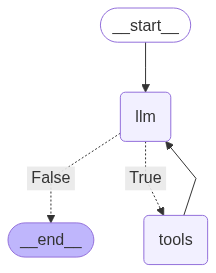

In [26]:
# Next, define a function that executes whenever an agent decides to call one or more tools.
# The execute_tools function above will be added to a LangGraph agent’s node, automatically receiving the agent’s current state.
#  We will only call the execute_tools() function if the agent decides to use one or both of these tools. 
def execute_tools(state: State):
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:

      if not t['name'] in tool_names:
        result = "Error: There's no such tool, please try again"
      else:
        result = tool_names[t['name']].invoke(t['args'])

        results.append(
          ToolMessage(
            tool_call_id=t['id'],
            name=t['name'],
            content=str(result)
          )
        )

    return {'messages': results}

#  define a function that checks whether the agent's latest state contains tool calls.
def tool_exists(state: State):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0

# now build graph with tool nodes and edges
graph_builder=StateGraph(State)
graph_builder.add_node("llm", run_llm)
graph_builder.add_node("tools", execute_tools)
graph_builder.add_conditional_edges(
    "llm",
     tool_exists,
    {True: "tools", False: END}
    )

graph_builder.add_edge("tools", "llm")
graph_builder.set_entry_point("llm")
graph=graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
# The agent we have decides if it will need the tools we defined to answer a user query:
# below is an exmaple where it will need a tool (arxiv)
messages = [HumanMessage(content="Give me the latest research paper on attention is all you need")]
result = graph.invoke({"messages": messages})
result

[HumanMessage(content='Give me the latest research paper on attention is all you need', additional_kwargs={}, response_metadata={})]
[HumanMessage(content='Give me the latest research paper on attention is all you need', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'function_call': {'name': 'arxiv_search', 'arguments': '{"topic": "attention is all you need"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 60, 'candidates_token_count': 9, 'total_token_count': 69, 'prompt_tokens_details': [{'modality': 1, 'token_count': 60}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 9}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.007037736475467682, 'model_name': 'gemini-2.0-flash-001'}, id='run--1abf516a-f3fc-46d3-b6aa-18d281fc2503-0', tool_calls=[{'name': 'arxiv_search', 'args': {'topic': 'attention is all you need'}, 'id'

{'messages': [HumanMessage(content='Give me the latest research paper on attention is all you need', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'arxiv_search', 'arguments': '{"topic": "attention is all you need"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 60, 'candidates_token_count': 9, 'total_token_count': 69, 'prompt_tokens_details': [{'modality': 1, 'token_count': 60}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 9}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.007037736475467682, 'model_name': 'gemini-2.0-flash-001'}, id='run--1abf516a-f3fc-46d3-b6aa-18d281fc2503-0', tool_calls=[{'name': 'arxiv_search', 'args': {'topic': 'attention is all you need'}, 'id': '8bc95912-3918-4286-b020-19b58f9d1ddf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 60, 'output_tokens': 

In [30]:
# When the agent does not need a tool, it will return a response from the LLM (Gemini), e.g this query
messages = [HumanMessage(content="How many months are in a year?")]
result = graph.invoke({"messages": messages})
result

[HumanMessage(content='How many months are in a year?', additional_kwargs={}, response_metadata={})]


{'messages': [HumanMessage(content='How many months are in a year?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='There are 12 months in a year.\n', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 56, 'candidates_token_count': 11, 'total_token_count': 67, 'prompt_tokens_details': [{'modality': 1, 'token_count': 56}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 11}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -1.3806433840231461e-05, 'model_name': 'gemini-2.0-flash-001'}, id='run--9e637720-629f-474e-96ad-0fe66871a195-0', usage_metadata={'input_tokens': 56, 'output_tokens': 11, 'total_tokens': 67})]}

In [29]:
# We can also stream the individual responses from all nodes and edges in the LangGraph agent. 
# Streaming messages allows users to receive responses in real-time. 
# To do so, we can call the stream() function instead of the invoke() method
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

messages = [HumanMessage(content="Who is Christiano Ronaldo")]
print_stream(graph.stream({"messages": messages}, stream_mode= "values"))

================================ Human Message =================================

Who is Christiano Ronaldo
[HumanMessage(content='Who is Christiano Ronaldo', additional_kwargs={}, response_metadata={})]
================================== Ai Message ==================================
Tool Calls:
  wikipedia_search (34a4867d-c5df-4b90-9145-cf23cd3745d5)
 Call ID: 34a4867d-c5df-4b90-9145-cf23cd3745d5
  Args:
    topic: Cristiano Ronaldo
================================= Tool Message =================================
Name: wikipedia_search

Cristiano Ronaldo dos Santos Aveiro (Portuguese pronunciation: [kɾiʃˈtjɐnu ʁɔˈnaldu] ; born 5 February 1985) is a Portuguese professional footballer who plays as a forward for and captains both Saudi Pro League club Al-Nassr and the Portugal national team. Nicknamed CR7, he is widely regarded as one of the greatest players of all time, and has won numerous individual accolades throughout his professional footballing career, including five Ballon d'Or a

In [28]:
from pprint import pprint

def format_paper_results(result):
    # Extract the ToolMessage containing arXiv results
    tool_message = next(m for m in result['messages'] if isinstance(m, ToolMessage))
    papers = tool_message.content.split('\n\nPublished: ')[1:] 
    
    print("📚 Latest Research Papers on 'Attention Is All You Need':\n")
    for i, paper in enumerate(papers, 1):
        # Extract components
        parts = paper.split('\n')
        published = parts[0]
        title = parts[1].replace('Title: ', '')
        authors = parts[2].replace('Authors: ', '')
        summary = '\n'.join(parts[3:]).replace('Summary: ', '')
        
        print(f"🔹 Paper #{i}")
        print(f"   🗓️ Published: {published}")
        print(f"   📜 Title: {title}")
        print(f"   👥 Authors: {authors}")
        print(f"   📝 Summary: {summary}\n")
        print("-" * 80 + "\n")

format_paper_results(result)

📚 Latest Research Papers on 'Attention Is All You Need':

🔹 Paper #1
   🗓️ Published: 2021-07-16
   📜 Title: All the attention you need: Global-local, spatial-channel attention for image retrieval
   👥 Authors: Chull Hwan Song, Hye Joo Han, Yannis Avrithis
   📝 Summary: We address representation learning for large-scale instance-level image
retrieval. Apart from backbone, training pipelines and loss functions, popular
approaches have focused on different spatial pooling and attention mechanisms,
which are at the core of learning a powerful global image representation. There
are different forms of attention according to the interaction of elements of
the feature tensor (local and global) and the dimensions where it is applied
(spatial and channel). Unfortunately, each study addresses only one or two
forms of attention and applies it to different problems like classification,
detection or retrieval.
  We present global-local attention module (GLAM), which is attached at the end
of a back